<div>
    <center>
        <h1>
            <font color="#902e59">CQF June 2023 Intake: Final Project</font>
        </h1>
    </center>
    <center>
        <h3>Deep Learning for Asset Prediction</h3>
    </center>
    <center>
        <h5>Will Colgate, Singapore, January 2024</h5>
    </center>
    <center>
        <a href='https://github.com/will-j-c/cqf_final_project_DL'>
            <svg height="32" aria-hidden="true" viewBox="0 0 16 16" width="32">
            <path d="M8 0c4.42 0 8 3.58 8 8a8.013 8.013 0 0 1-5.45 7.59c-.4.08-.55-.17-.55-.38 0-.27.01-1.13.01-2.2 0-.75-.25-1.23-.54-1.48 1.78-.2 3.65-.88 3.65-3.95 0-.88-.31-1.59-.82-2.15.08-.2.36-1.02-.08-2.12 0 0-.67-.22-2.2.82-.64-.18-1.32-.27-2-.27-.68 0-1.36.09-2 .27-1.53-1.03-2.2-.82-2.2-.82-.44 1.1-.16 1.92-.08 2.12-.51.56-.82 1.28-.82 2.15 0 3.06 1.86 3.75 3.64 3.95-.23.2-.44.55-.51 1.07-.46.21-1.61.55-2.33-.66-.15-.24-.6-.83-1.23-.82-.67.01-.27.38.01.53.34.19.73.9.82 1.13.16.45.68 1.31 2.69.94 0 .67.01 1.3.01 1.49 0 .21-.15.45-.55.38A7.995 7.995 0 0 1 0 8c0-4.42 3.58-8 8-8Z"></path>
        </a>
    </center>
</svg>
</div>


### Introduction

Using machine and deep learning techniques to predict price movements is considered the holy grail of modern finance, with great focus from both individual professionals and hobbyists, to large multi national businesses with mixed results. Given the stochastic nature of markets, it is arguable if a reliable algorithm can be found that is actually effective in the "wild".

Operational complexities such as timely access to information, the brokerage spread and transaction costs make the task difficult before even considering the more philisophical question on how perfect the markets are. This is ratcheted up a notch with the irrational movements of crypto markets, which arguably have no underlying inherent value. 

Applying deep learning to these markets, whilst offering an interesting academic problem to explore, are unlikely to offer additional insight and the below should not be used as a basis for any investment decisions.

### A Note on the Project Workflow

The approach to this problem will follow the well trodden machine learning workflow as follows:

- Problem statements
- Data collection
- Exploratory data analysis
- Data cleaning
- Feature scaling and selection
- Model design and hypertuning
- Model evaluation

Given the subject matter is financial timeseries forcasting, the report will also include backtesting of the predictions versus a long only hold strategy, to understand if it achieves its objective.

A full process diagram is included in Appendix 1.

### Problem Statement

The objective is to produce a model that can predict positive moves using Long Short-Term Memory (LSTM) networks in short term financial time series.

I have chosen Ethereum (ETH) as the ticker to analyse (technically a pair with USD). Crypto markets are notoriously volatile and it seems like a decent challenge to try and tease some insight out of the mess.

For this purpose, I will aim to predict an hourly positive return. Defining a positive return is discussed in more detail as part of the labels section. This will be a binary classification problem with 1 being the label for a positive move and 0 otherwise.

Whilst accuracy of the predictions will be an important metric, precision and recall will arguably be more important as measures of success. The precision of calculating the upward moves in particular would be important as there is a realised financial loss from buying and selling at a loss in a high frequency setting. A thorough discussion of metrics is considered in the following pages. 

In [2]:
# Imports
from src.plots import *

# Base
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_row', 500)
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Feature engineering
import pandas_ta as ta

# Models

# Warnings
import warnings
warnings.filterwarnings("ignore")

2024-01-04 21:01:28.862158: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 21:01:28.900612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 21:01:28.900637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 21:01:28.901355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 21:01:28.906404: I tensorflow/core/platform/cpu_feature_guar

### Data Collection

##### Raw Data

Access to data is one of the biggest problems for deep learning problems. The amount of data required to train a (good) deep learning neural network is usually much more than is available outside of a professional setting. High frequency intraday data especially is difficult to come by, presumably due to the differences in exchanges, the cost of storage and how valuable the data can be.

After exploring Yahoo Finance (via the `yfinance` python package) and the Alpha Vantage API, it became appararant that these sources did not have the amount of data required or reliable data.

In the end, the data was sourced from [https://www.cryptodatadownload.com/data/]() from the data available from the Gemini exchange.

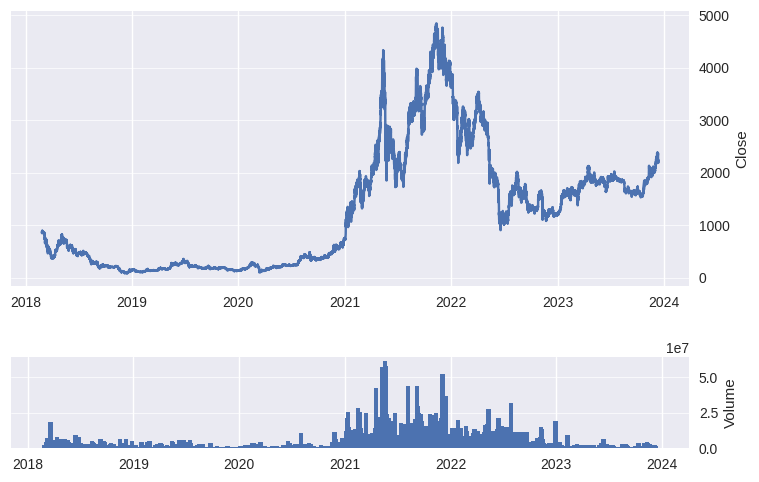

In [3]:
# Plotting closing price and volume
df = pd.read_csv('data/unscaled_clean_data.csv', parse_dates=True, index_col='unix')
plot_price_vol(df, 'close', 'volume')

In [4]:
df.head()

,open,high,low,close,volume,fg_value,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,ADXR_14_2,DMP_14,DMN_14,AGj_13_8_5,AGt_13_8_5,AGl_13_8_5,ALMA_9_6.0_0.85,ALPHAT_14_1_50,ALPHATl_14_1_50_2,AMATe_LR_8_21_2,AMATe_SR_8_21_2,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,APO_12_26,AROOND_14,AROONU_14,AROONOSC_14,ATRr_14,ATRTSe_14_20_3.0,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CDL_3WHITESOLDIERS,CDL_ADVANCEBLOCK,CDL_BELTHOLD,CDL_CLOSINGMARUBOZU,CDL_DOJI_10_0.1,CDL_DRAGONFLYDOJI,CDL_GRAVESTONEDOJI,CDL_HAMMER,CDL_HANGINGMAN,CDL_HIGHWAVE,CDL_HIKKAKE,CDL_HIKKAKEMOD,CDL_IDENTICAL3CROWS,CDL_INSIDE,CDL_LONGLEGGEDDOJI,CDL_LONGLINE,CDL_MARUBOZU,CDL_MATCHINGLOW,CDL_RICKSHAWMAN,CDL_SEPARATINGLINES,CDL_SHORTLINE,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_TAKURI,open_Z_30_1,high_Z_30_1,low_Z_30_1,close_Z_30_1,CFO_9,CG_10,CHDLREXTl_22_22_14_2.0,CHDLREXTs_22_22_14_2.0,CHDLREXTd_22_22_14_2.0,CHOP_14_1_100.0,CKSPl_10_3_20,CKSPs_10_3_20,CMF_20,CMO_14,COPC_11_14_10,CRSI_3_2_100,CTI_12,CUBE_3.0_-1,CUBEs_3.0_-1,LDECAY_1,DEC_1,DEMA_10,DCL_20_20,DCM_20_20,DCU_20_20,DPO_20,EBSW_40_10,EFI_13,EMA_10,ENTP_10,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,FWMA_10,HA_open,HA_high,HA_low,HA_close,HILO_13_21,HL2,HLC3,HMA_10,HWM_1,HWU_1,HWL_1,HWMA_0.2_0.1_0.1,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,INVFISHER_1.0,INVFISHERs_1.0,INC_1,INERTIA_20_14,JMA_7_0.0,KAMA_10_2_30,KCLe_20_2,KCBe_20_2,KCUe_20_2,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,KURT_30,KVO_34_55_13,KVOs_34_55_13,LINREG_14,LOGRET_1,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MAD_30,MAMA_0.5_0.05,FAMA_0.5_0.05,MASSI_9_25,MCGD_10,MEDIAN_30,MFI_14,MIDPOINT_2,MIDPRICE_2,MOM_10,NATR_14,NVI_1,OHLC4,PDIST,PCTRET_1,PGO_14,PIVOTS_TRAD_D_P,PIVOTS_TRAD_D_S1,PIVOTS_TRAD_D_S2,PIVOTS_TRAD_D_S3,PIVOTS_TRAD_D_S4,PIVOTS_TRAD_D_R1,PIVOTS_TRAD_D_R2,PIVOTS_TRAD_D_R3,PIVOTS_TRAD_D_R4,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSARaf_0.02_0.2,PSARr_0.02_0.2,PSL_12,PVI_1,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,PVOL,PVR,PVT,PWMA_10,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QS_10,QTL_30_0.5,REFLEX_20_20_0.04,REMAP_0.0_100.0_-1.0_1.0,RMA_10,ROC_10,RSI_14,RSX_14,RVGI_14_4,RVGIs_14_4,RVI_14,RWIh_14,RWIl_14,SINWMA_14,SKEW_30,SLOPE_1,SMA_10,SMI_5_20_5_1.0,SMIs_5_20_5_1.0,SMIo_5_20_5_1.0,SMMA_7,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZPRO_20_2.0_20_2.0_1.5_1.0,SQZPRO_ON_WIDE,SQZPRO_ON_NORMAL,SQZPRO_ON_NARROW,SQZPRO_OFF,SSF_20,SSF3_20,STC_10_12_26_0.5,STCmacd_10_12_26_0.5,STCstoch_10_12_26_0.5,STDEV_30,STOCHk_14_3_3,STOCHd_14_3_3,STOCHh_14_3_3,STOCHFk_14_3,STOCHFd_14_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,SUPERT_7_3.0,SUPERTd_7_3.0,SWMA_10,T3_10_0.7,TEMA_10,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TMO_14_5_3,TMOs_14_5_3,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,TRENDFLEX_20_20_0.04,TRIMA_10,TRIX_30_9,TRIXs_30_9,TRUERANGE_1,TSI_13_25_13,TSIs_13_25_13,TTM_TRND_6,UI_14,UO_7_14_28,VAR_30,VHF_28,VHM_610,VTXP_14,VTXM_14,VWAP_D,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,fg_value_classification_extreme fear,fg_value_classification_extreme greed,fg_value_classification_fear,fg_value_classification_greed,fg_value_classification_neutral,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,label
unix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [5]:
df.tail()

,open,high,low,close,volume,fg_value,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,ADXR_14_2,DMP_14,DMN_14,AGj_13_8_5,AGt_13_8_5,AGl_13_8_5,ALMA_9_6.0_0.85,ALPHAT_14_1_50,ALPHATl_14_1_50_2,AMATe_LR_8_21_2,AMATe_SR_8_21_2,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,APO_12_26,AROOND_14,AROONU_14,AROONOSC_14,ATRr_14,ATRTSe_14_20_3.0,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CDL_3WHITESOLDIERS,CDL_ADVANCEBLOCK,CDL_BELTHOLD,CDL_CLOSINGMARUBOZU,CDL_DOJI_10_0.1,CDL_DRAGONFLYDOJI,CDL_GRAVESTONEDOJI,CDL_HAMMER,CDL_HANGINGMAN,CDL_HIGHWAVE,CDL_HIKKAKE,CDL_HIKKAKEMOD,CDL_IDENTICAL3CROWS,CDL_INSIDE,CDL_LONGLEGGEDDOJI,CDL_LONGLINE,CDL_MARUBOZU,CDL_MATCHINGLOW,CDL_RICKSHAWMAN,CDL_SEPARATINGLINES,CDL_SHORTLINE,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_TAKURI,open_Z_30_1,high_Z_30_1,low_Z_30_1,close_Z_30_1,CFO_9,CG_10,CHDLREXTl_22_22_14_2.0,CHDLREXTs_22_22_14_2.0,CHDLREXTd_22_22_14_2.0,CHOP_14_1_100.0,CKSPl_10_3_20,CKSPs_10_3_20,CMF_20,CMO_14,COPC_11_14_10,CRSI_3_2_100,CTI_12,CUBE_3.0_-1,CUBEs_3.0_-1,LDECAY_1,DEC_1,DEMA_10,DCL_20_20,DCM_20_20,DCU_20_20,DPO_20,EBSW_40_10,EFI_13,EMA_10,ENTP_10,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,FWMA_10,HA_open,HA_high,HA_low,HA_close,HILO_13_21,HL2,HLC3,HMA_10,HWM_1,HWU_1,HWL_1,HWMA_0.2_0.1_0.1,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,INVFISHER_1.0,INVFISHERs_1.0,INC_1,INERTIA_20_14,JMA_7_0.0,KAMA_10_2_30,KCLe_20_2,KCBe_20_2,KCUe_20_2,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,KURT_30,KVO_34_55_13,KVOs_34_55_13,LINREG_14,LOGRET_1,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MAD_30,MAMA_0.5_0.05,FAMA_0.5_0.05,MASSI_9_25,MCGD_10,MEDIAN_30,MFI_14,MIDPOINT_2,MIDPRICE_2,MOM_10,NATR_14,NVI_1,OHLC4,PDIST,PCTRET_1,PGO_14,PIVOTS_TRAD_D_P,PIVOTS_TRAD_D_S1,PIVOTS_TRAD_D_S2,PIVOTS_TRAD_D_S3,PIVOTS_TRAD_D_S4,PIVOTS_TRAD_D_R1,PIVOTS_TRAD_D_R2,PIVOTS_TRAD_D_R3,PIVOTS_TRAD_D_R4,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSARaf_0.02_0.2,PSARr_0.02_0.2,PSL_12,PVI_1,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,PVOL,PVR,PVT,PWMA_10,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QS_10,QTL_30_0.5,REFLEX_20_20_0.04,REMAP_0.0_100.0_-1.0_1.0,RMA_10,ROC_10,RSI_14,RSX_14,RVGI_14_4,RVGIs_14_4,RVI_14,RWIh_14,RWIl_14,SINWMA_14,SKEW_30,SLOPE_1,SMA_10,SMI_5_20_5_1.0,SMIs_5_20_5_1.0,SMIo_5_20_5_1.0,SMMA_7,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZPRO_20_2.0_20_2.0_1.5_1.0,SQZPRO_ON_WIDE,SQZPRO_ON_NORMAL,SQZPRO_ON_NARROW,SQZPRO_OFF,SSF_20,SSF3_20,STC_10_12_26_0.5,STCmacd_10_12_26_0.5,STCstoch_10_12_26_0.5,STDEV_30,STOCHk_14_3_3,STOCHd_14_3_3,STOCHh_14_3_3,STOCHFk_14_3,STOCHFd_14_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,SUPERT_7_3.0,SUPERTd_7_3.0,SWMA_10,T3_10_0.7,TEMA_10,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TMO_14_5_3,TMOs_14_5_3,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,TRENDFLEX_20_20_0.04,TRIMA_10,TRIX_30_9,TRIXs_30_9,TRUERANGE_1,TSI_13_25_13,TSIs_13_25_13,TTM_TRND_6,UI_14,UO_7_14_28,VAR_30,VHF_28,VHM_610,VTXP_14,VTXM_14,VWAP_D,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,fg_value_classification_extreme fear,fg_value_classification_extreme greed,fg_value_classification_fear,fg_value_classification_greed,fg_value_classification_neutral,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,label
unix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

The data appears to be relatively complete on an arbitary inspection and shows the meteoric rise of the crypto markets generally in 2021 and 2022 followed by the collapse in price due to the FTX and LUNA scandals. The raw data goes backt o 2016, but us truncated above in the above chart for the reasons explained in the next few paragraphs. 

The crypto market is notoriously emotion driven. Even glancing at social maedia or news outlets allows a person to gain a sense of how this is true. It follows then that some kind of sentiment regarding this emotional investing would potentially give some interesting insight into the problem statement. There is an interesting resource updated daily on [alternative.me](https://alternative.me/crypto/fear-and-greed-index/) called the fear and greed index. 

The index takes a weighted approach to a number of factors across 5 (formally, 6) datasources. A numerical value is assigned which falls into categories of:

- Extreme Fear
- Fear
- Neutral
- Greed
- Extreme Greed

The index is updated daily at 00:00 UTC.

In [6]:
# Load fear and greed data
df_fear_greed = pd.read_csv('data/raw/crypto_greed_fear_index.csv', parse_dates=True, index_col='timestamp')
# Drop unneeded columns
df_fear_greed.drop(['time_until_update', 'timestamp.1'], axis=1, inplace=True)
# Rename columns
df_fear_greed.columns = ['fg_value', 'fg_value_classification']
# Put classification to lower case
df_fear_greed['fg_value_classification'] = df_fear_greed['fg_value_classification'].str.lower()
df_fear_greed.head()

,fg_value,fg_value_classification
timestamp,,
2023-12-23 00:00:00+00:00,70,greed
2023-12-22 00:00:00+00:00,74,greed
2023-12-21 00:00:00+00:00,70,greed
2023-12-20 00:00:00+00:00,74,greed
2023-12-19 00:00:00+00:00,73,greed


The index could be a good indicator of sentiment in the crypto market as a whole. Crypto tokens do not have fundemental data so a taditional fundemental analysis cannot be undertaken. However, there are metrics associated with blockchains that can be accessed (such as transactions per second, blocks mined etc) that could be worth exploring in a further analysis but are outside the scope of this paper. 

The index only began on 1 February 2018 so all price data before this date has been dropped and the the daily metric forward filled to the hourly data. This would reflect that the index would apply to the price movements throughout the day. 

##### Feature Engineering

Feature engineering is the catch all term for using domain knowledge to generate insights from the raw dataset. Common data transformations for financial times series are known as technical analysis with associated literature that spans many volumes.

Using `pandas-ta`, I have generated standard technical indicators for the data based on high, low, open, close and volume. I have also generated temporal data to investigate if there is any kind of seasonaility to returns. I have used the `scikit-learn` OneHotEncoder to encode these values (and the FG classification) into binary variables.

Interestingly, the `pandas-ta` module implements TA-Lib and candlestick patterns. Reading candlesticks is a classical version of technical analysis, reportably from the rice markets of Japan. Recognising what patterns lead to an upward tick will be interesting to see.

##### Labelling the Data

Given the problem statement is to predict an hourly positive return. The 1 period return is calculated as follows:

$$
r_t = ln(\frac{p_t}{p_{t-1}})
$$

A practical approach to predicting a positve return for these purposes would be any net reuturn (i.e. after transaction costs).

[Here](https://www.gemini.com/fees/api-fee-schedule) are the fees from the Gemini exchange for reference. The taker fee at the lowest volume per month is 0.4%. To account for interest on margin, I will round this up to 0.5% as an estimate.

Therefore, a label of 1 will mean that that the upward return in the next hour will be greater than 0.05% and 0 otherwise. Mathamatically:

$$ y_t =
  \begin{cases}
    1      & \quad \text{if  } r_{t+1} > 0.005\\
    0  & \quad \text{otherwise}
  \end{cases}
$$

### Exploratory Data Analysis

- describe the data and discuss it
- correlation heatmap
- outlier detection using IQR

The summary statistics for the data is found in appendix 1. A few observations from this data:

- There are a number of features where the min and max is zero, indicating these features can be removed.
- There are various features with nonsensical data (such as infinity values). These can be removed.
- The time data and greed index descriptions will likely need to be encoded in vectors to feed into the deep learning algorithm.

Given the high dimension of the data, a pairplot will be computationally expensive and would take a large amount of time to analyse.



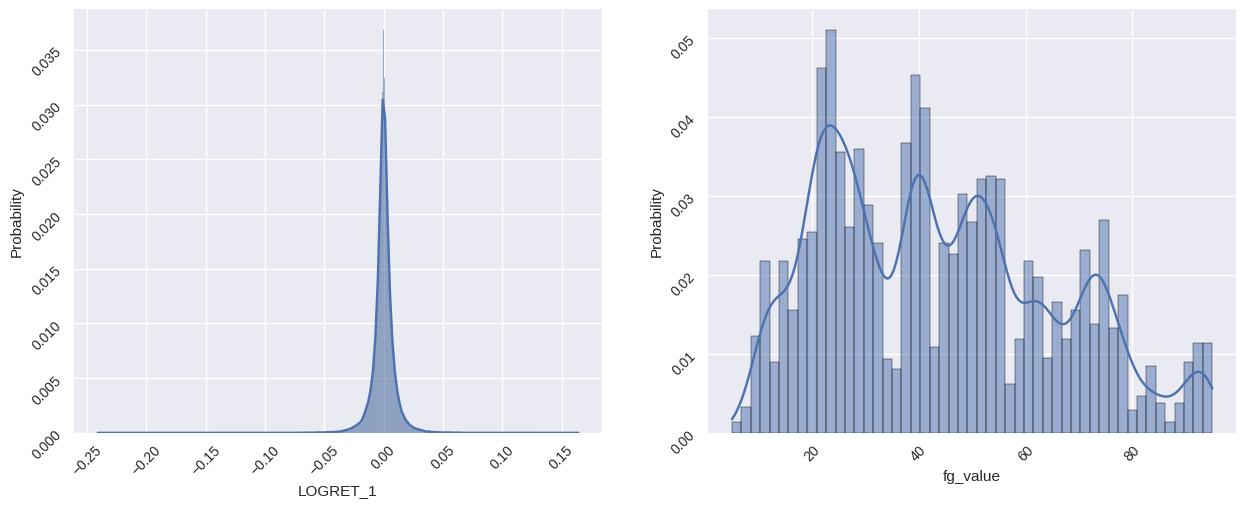

In [7]:
# Plot 
fig, axes = plt.subplots(1, 2)
sns.histplot(df, x='LOGRET_1', kde=True, ax=axes[0], stat='probability')
sns.histplot(df, x='fg_value', kde=True, ax=axes[1], stat='probability')
for ax in axes:
    ax.tick_params(labelrotation=45)
fig.set_figwidth(15)
plt.show()

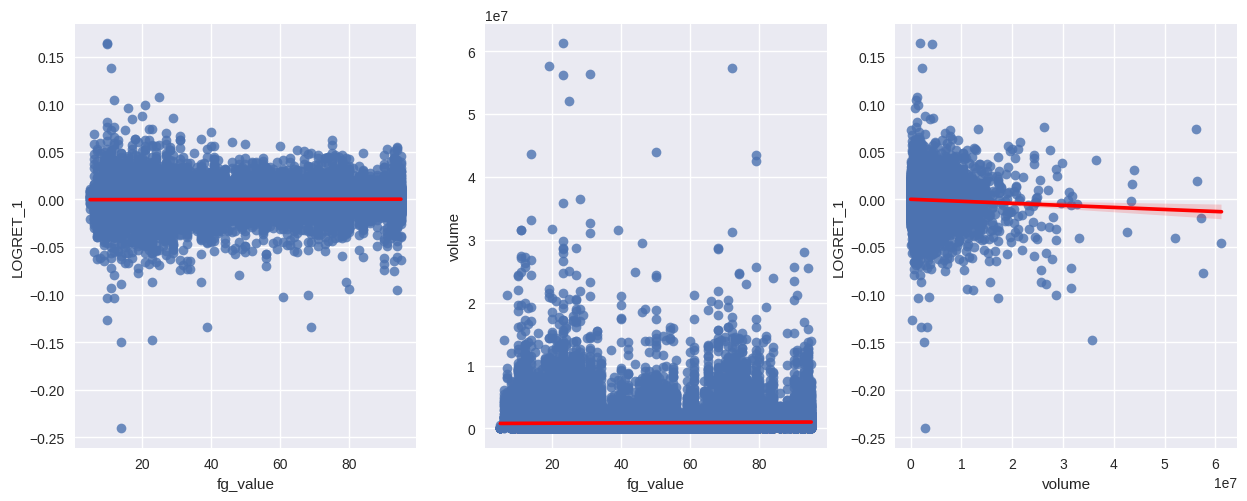

In [8]:
fig, axes = plt.subplots(1, 3)
sns.regplot(data=df, x='fg_value', y='LOGRET_1', ax=axes[0], line_kws=dict(color='r'))
sns.regplot(data=df, x='fg_value', y='volume', ax=axes[1], line_kws=dict(color='r'))
sns.regplot(data=df, x='volume', y='LOGRET_1', ax=axes[2], line_kws=dict(color='r'))
fig.set_figwidth(15)
plt.show()

Some observations from the above data:

- Return does not seem to be correlated with fg_value. However, higher fg_values (i.e. more greed in the index), seems to see the variance decrease (heteroscedasticity).
- There appears to be a slight negative correlation with fg_value and volume, indicating that less volume is traded during times of greed in the index. 
- Return does not have significatn outliers but volume does so would be a candidate for robust scaler.

In [9]:
# fig, axes = plt.subplots(1, 3)
# sns.regplot(data=df, x='hour', y='LOGRET_1', ax=axes[0], line_kws=dict(color='r'))
# sns.regplot(data=df, x='day_of_week', y='LOGRET_1', ax=axes[1], line_kws=dict(color='r'))
# sns.regplot(data=df, x='month', y='LOGRET_1', ax=axes[2], line_kws=dict(color='r'))
# fig.set_figwidth(15)
# plt.show()

Some observations from the above data:

- There seems to be greater variation in returns around June over the prior two years indicating at least some seasonality. 

Some observations from the above data

- PVOL has outliers and would benefit from a robust scaler.
- CUBE features do not have particular outliers and should be fine with the min max scaler. 

In [10]:
# Checking for class imbalances
df['label'].value_counts()

label
0    40858
1     9809
Name: count, dtype: int64

The above does indicate that there is quite a severe class imbalance in the data that will need to be addressed at the model building stage otherwise the model will likely underperform due to bias.

Next, I have examined the correlation between features. Collinearity between features is present and there are a number of features that will need cleaning before they can be used in the model. 

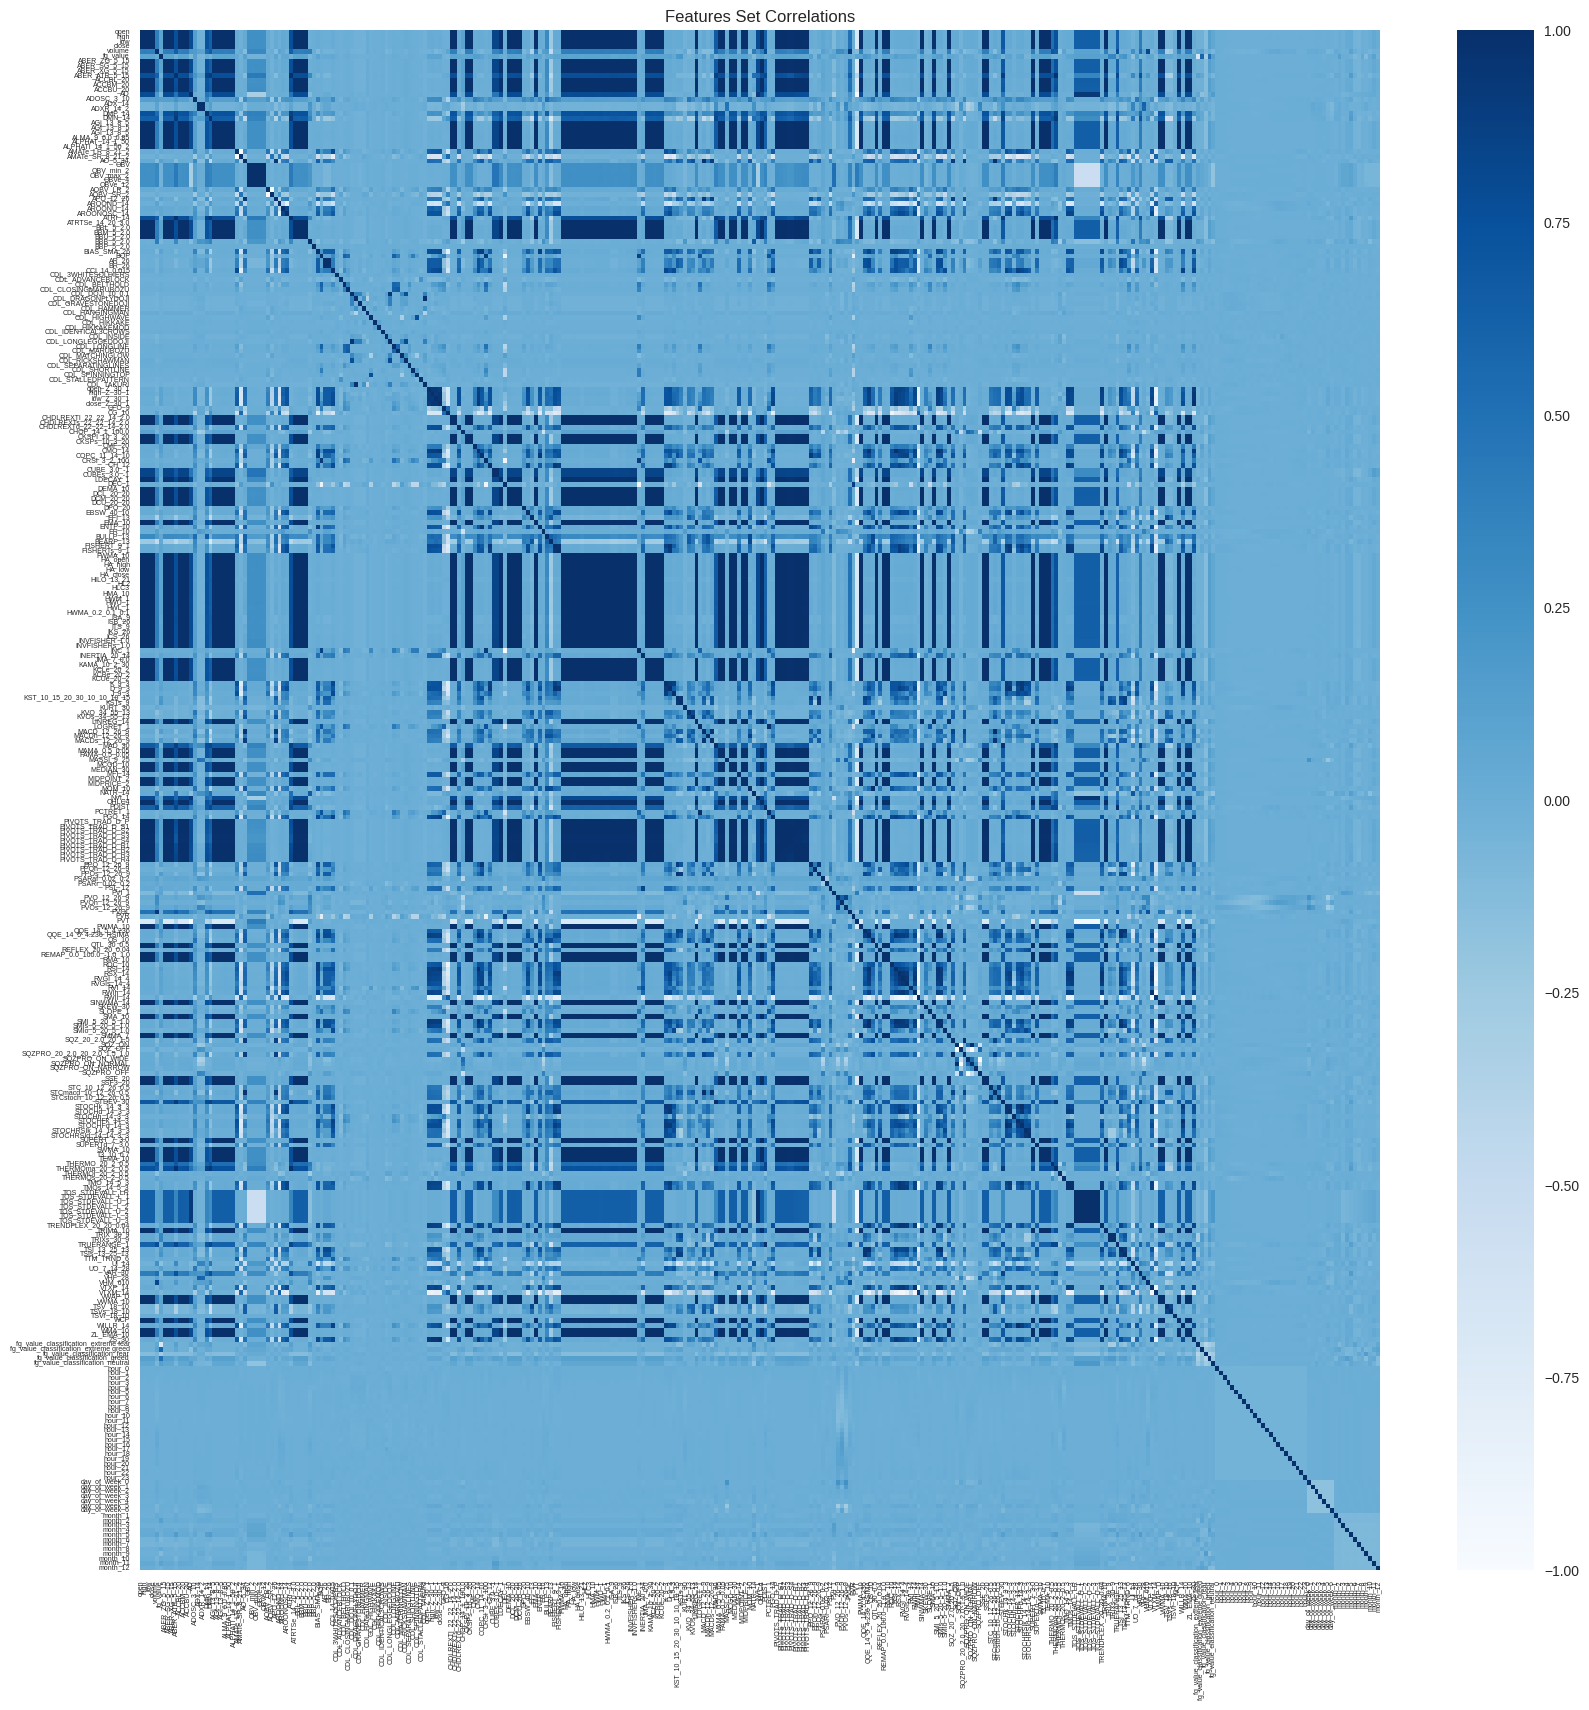

In [11]:
# Create a heatmap in Seaborn to see the features that are highly correlated and seek to remove them
X_cov = df.drop('label', axis=1).corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(X_cov, cbar=True, xticklabels=True, yticklabels=True, cmap='Blues')
plt.tick_params(labelsize=5)
plt.title('Features Set Correlations')
plt.show()

The heatmap of cleaned features shows clear collinearity between a number of features. Collinearity in ML problems affects performance and interpretability and so is generally best removed. There are multiple methods of doing this but in this paper, I have focused on the following two methods:

- Taking the first variable in a highly correlated pair
- Discarding variables with a variance inflation factor of greater than 5

The first method is self explanatory, the second is defined as:

$$
VIF_i = \frac{1}{1-R^{2}_{i}}
$$

Where $R^{2}_{i}$ is the unadjsuted coefficient of determination for regressing variable $i$on all the remaining independent variables. A VIF equal to 1 indicates that the variables are not correlated, betwen 1 and 5, that there is moderate correlation between that variable and others and greater than 5 indicating high correlation with other varibles. 

### Data Cleaning

As already alluded to in the proceeding sectons, the joining of the two raw data sources and computation of the technical indicators requires some cleaning. A number of steps have been taken to deal with this in the `clean_scale.py` script. These are:

- Drop all columns where `pandas.ta` has calculated NaN.
- Drop columns where 20,000 datapoints (out of 65k+) are missing.
- Remove the leading NaN rows of data due to calculation of rolling amounts (simples moving averages etc.).
- Removal of all columns with no variance, indicating a single value. This is because no variance in the data indicates no informative information for the algorithm. 

After this process, there are 324 features remaining in the dataset with hourly data from 26/02/2018 until 11/12/2023.

### Feature Scaling

- discussion on scaling types
- table of which features will be scaled
- split into train and test first
- apply the scaler to each column as needed

In order to get the best results from deep learning models, data generally needs to be scaled to aid in faster calculation of cost functions during gradient descent. There are various scaling techniques commonly used but this model concentrates on two.

##### Min Max Scaler

The min max scaler rescales all features to within a range based on the following calculation:

$$
x_{scaled} = \frac{x_i - min(x)}{max(x) - min(x)}
$$

This scaler is relatively sensitive to outliers.

##### Robust Scaler

The Robust Scaler scales variables with significant outliers by using the quartiles of X to scale the variables. 

$$
x_{scaled} = \frac{x_i - Q_{1}(x)}{Q_{3}(x) - Q_{1}(x)} = \frac{x_i - Q_{1}(x)}{IQR(x)}
$$

A significant outlier is calculated for the purposes of this paper as one that is 10 times the IQR. Appendix 2 lists each feature remianing after cleaning the data and the scaler applied to each.

##### Split Data into Train and Test

Before applying the chosen sclaing methods to each column, the data needs to be split into train and test data. This is because the scaling algorithm will be fit to the training data only and the test data scaled using metrics calculated on the training data only. This technique helps to avoid data leakage of the test data into the training dataset and also helps with regularization. Note that as this is time series data, the data should not be shuffled.

Once the train and test data are split, the train data is split again into a train and validation set test the mdoel during the training process. 

All sets are then scaled using $x$ values calculated from the training set only to avoid any data leakage. 

### Feature Selection

There are many (and varied) techniques to feature selection and feature engineering as a whole necessitating experimentation to try and meet the main objective of an efficient model with good predicitive powers.

To attempt to achieve this, I have split the problem into four stages stages:

1. Removal of collinearity using one of the two techniques described above.
2. Use of boruta as a feature selection algorithm.
3. Dimension reduction using Uniform Manifold Approximation & Projection (UMAP), a relatively new and novel unsipervised learning algorith.
4. Input the results of the above pipeline (or part there of) into a baseline one layer LSTM model using `keras`.

##### Boruta

##### UMAP

Per the documentation, UMAP is a dimension reduction technique that can be used for visualisation similarly to t-distributed Stochastic Neighbor Embedding (t-SNE), but also for general non-linear dimension reduction. The mathamatics can be found in *McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*.

The python implementation of UMAP takes a number of parameters but there are two main parameters that impact the clustering of the algoithm on the 2D plane.

n_neighbors - This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. Lower values of n_neighbours force the algorithm to focus more on the local structure, potentailly losing some of the global structure and vice versa. 10

min_dist - This parameter controls how tightly UMAP is allowed to pack points together is the 2D representation. A lower min_dist generally means that points will clump together more. The choice of min_dist will depend on the use case of the algorithm, with a lower value generally being more useful for clustering problems. 0.1 (default)

Appendix 3 explores the output of the algorithm on changing the above parameters and demonstrates why the above were chosen as a middle ground on local and global structure to use for dimension reduction of the dataset.

##### Baseline Model

##### Experiment Results

##### Pipeline Selection


### Deep Learning Model

- address class imbalance 
- base line model of 1 LSTM
- no dimensionality reduction vs umap reduction vs SOM reduction
- hypertune these models
- computational time for each model and details of what it was run on
- save this and all assets into tensorboard
- discuss the models


### Model Evaluation

- summary reports
- confusion matrix
- AUC reports
- computational time

### Backtesting

- pyfolio vs writing something myself?
- long only vs long hold
- long/short vs long hold

### Appendices

##### Appendix 1 - Process Diagram

##### Appendix 2 - Features and Scalers

In [20]:
appendix_2 = pd.read_csv('static/scalers.csv', index_col='scaler')
appendix_2

,feature
scaler,
RobustScaler,ABER_ATR_5_15
MinMaxScaler,ABER_SG_5_15
MinMaxScaler,ABER_XG_5_15
MinMaxScaler,ABER_ZG_5_15
MinMaxScaler,ACCBL_20
MinMaxScaler,ACCBM_20
MinMaxScaler,ACCBU_20
MinMaxScaler,AD
RobustScaler,ADOSC_3_10
